In [ ]:
#人名分类器
#步骤：
#----数据处理 ：清洗数据 构建数据源Dataset（文本张量化） 构建数据迭代器dataset再次封装
#----模型构建 ：RNN系列模型
#----模型训练
#----模型评估

In [6]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim#优化器
from torch.utils.data import Dataset,DataLoader
import string
import time
import matplotlib.pyplot as plt
from tqdm import tqdm#进度条
import json

In [7]:
#获取常用的字符数量 也就是onehot去重之后的词汇总量
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


In [8]:
#获取国家以及种类数
categorys = ['Italian', 'English', 'Arabic', 'Spanish', 'Scottish', 'Irish', 'Chinese',
              'Vietnamese','French', 'Greek', 'Dutch', 'Korean', 'Polish', 'Portuguese',
              'Russian', 'Czech', 'German','Japanese']
categorynum = len(categorys)
print(categorynum)

18


In [9]:
#数据读取到内存
def read_data(filename):
    #定义两个空列表 一个人名x一个国家y
    my_list_x,my_list_y = [],[]
    with open(filename,encoding = 'UTF-8') as f:
        for line in f.readlines():
            if len(line) <= 5:
                continue#脏数据去除掉
            (x,y) = line.strip().split('\t')#将字符串两边的空格去除掉strip) split按照\t切割 
            my_list_x.append(x)
            my_list_y.append(y)
    print(len(my_list_x),len(my_list_y))
    return my_list_x,my_list_y
#read_data('./name_classfication.txt')

In [10]:
class NameClassDataset(Dataset):
    def __init__(self, my_list_x, my_list_y):  # 确保这里是 __init__ 且有3个参数
        super().__init__()
        self.my_list_x = my_list_x
        self.my_list_y = my_list_y
        self.sample_len = len(my_list_x)
    
    def __len__(self):
        return self.sample_len
    
    def __getitem__(self, index):
        index = min(max(index, 0), self.sample_len - 1)
        x = self.my_list_x[index]
        y = self.my_list_y[index]
        
        tensor_x = torch.zeros(len(x), n_letters)
        for idx, letter in enumerate(x):
            tensor_x[idx][all_letters.find(letter)] = 1
        
        tensor_y = torch.tensor(categorys.index(y), dtype=torch.long)
        return tensor_x, tensor_y

In [11]:
#dataloader再次封装 会对数据进行增维度
def dm_test_NameClassDataset():
    myfilename = './name_classfication.txt'
    my_list_x , my_list_y = read_data(myfilename)
    name_dataset = NameClassDataset(my_list_x,my_list_y)
    train_dataloader = DataLoader(
        dataset  = name_dataset,
        batch_size = 1,
        shuffle = True
    )
    return train_dataloader
#train_dataloader = dm_test_NameClassDataset()
#for tensor_x,tensor_y in train_dataloader:
    #print(tensor_x)
    #print(tensor_y)
    #break

In [12]:
#构建模型
class RNN(nn.Module):

    def __init__(self,input_size,hidden_size,output_size,num_players=1):
        super(RNN,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_players=num_players
        #定义RNN 层（默认情况下 batch_size为False）
        self.rnn = nn.RNN(self.input_size,self.hidden_size,self.num_players)
        #定义linear层(输出层)
        self.linear = nn.Linear(self.hidden_size,self.output_size)
        #定义softmax层
        self.softmax = nn.LogSoftmax(dim = -1)
    def forward(self,input,hidden):
        #数据形状[6,57]  [6,1,57]
        input = input.unsqueeze(1)
        output,hn = self.rnn(input,hidden)
        #获取最后一个单词的隐藏层张量代表整个句子的语义
        temp = output[-1]
        result = self.linear(temp)#进行交叉熵
        return self.softmax(result),hn
    def inithidden(self):
        return torch.zeros(self.num_players,1,self.hidden_size)

In [13]:
#LSTM模型的搭建
#构建模型
class LSTM(nn.Module):

    def __init__(self,input_size,hidden_size,output_size,num_players=1):
        super(LSTM,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_players=num_players
        #定义RNN 层（默认情况下 batch_size为False）
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_players)
        #定义linear层(输出层)
        self.linear = nn.Linear(self.hidden_size,self.output_size)
        #定义softmax层
        self.softmax = nn.LogSoftmax(dim = -1)
    def forward(self,input,hidden,c):
        #数据形状[6,57]  [6,1,57]
        input = input.unsqueeze(1)
        output,(hn,cn) = self.lstm(input,(hidden,c))
        #获取最后一个单词的隐藏层张量代表整个句子的语义
        temp = output[-1]
        result = self.linear(temp)#进行交叉熵
        return self.softmax(result),hn,cn
    def inithidden(self):
        hidden = torch.zeros(self.num_players,1,self.hidden_size)
        c =  torch.zeros(self.num_players,1,self.hidden_size) 
        return hidden,c

In [14]:
#构建GRU模型
#构建模型
class GRU(nn.Module):

    def __init__(self,input_size,hidden_size,output_size,num_players=1):
        super(GRU,self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_players=num_players
        #定义gru层（默认情况下 batch_size为False）
        self.gru = nn.GRU(self.input_size,self.hidden_size,self.num_players)
        #定义linear层(输出层)
        self.linear = nn.Linear(self.hidden_size,self.output_size)
        #定义softmax层
        self.softmax = nn.LogSoftmax(dim = -1)
    def forward(self,input,hidden):
        #数据形状[6,57]  [6,1,57]
        input = input.unsqueeze(1)
        output,hn = self.gru(input,hidden)
        #获取最后一个单词的隐藏层张量代表整个句子的语义
        temp = output[-1]
        result = self.linear(temp)#进行交叉熵
        return self.softmax(result),hn
    def inithidden(self):
        return torch.zeros(self.num_players,1,self.hidden_size)

In [15]:
#构建训练函数并进行训练
#模型训练的超参数
mylr = 1e-3#学习率
epochs = 1#训练一轮
def my_train_rnn():
    #获取数据
    myfilename = './name_classfication.txt'
    my_list_x , my_list_y = read_data(myfilename)
    #实例化dataset对象
    name_dataset = NameClassDataset(my_list_x,my_list_y)
    #实例化模型
    input_size = 57
    hidden_size = 128
    output_size = 18
    rnn_model = RNN(input_size,hidden_size,output_size)
    #实例化损失函数adam优化器
    mycrossentropyloss = nn.NLLLoss()
    myadam = optim.Adam(rnn_model.parameters(),lr=mylr)#更新参数
    #定义模型训练参数
    #打印日志
    starttime = time.time()
    total_iter_num = 0#已训练的样本数
    total_loss = 0.0#一训练的损失和
    total_loss_list =[] ##每100个样本求一次平均损失形成损失列表
    total_acc_num = 0#已训练样本预测准确总数
    total_acc_list = [] ##每100个样本求一次平均准确率 形成平均准确率列表
    
    #外部for循环 控制轮数
    for epoch_idx in range(epochs):
        #实例化
        train_dataloader = DataLoader(dataset  = name_dataset,batch_size = 1,shuffle = True)
        #内部数据迭代
        for i ,(x,y) in enumerate(tqdm(train_dataloader)):
            h0=rnn_model.inithidden()
            output,hn = rnn_model(x[0],h0)
            my_loss = mycrossentropyloss(output,y)
            #梯度清零
            myadam.zero_grad()
            #反向传播
            my_loss.backward()
            #梯度更新
            myadam.step()
            #计算总损失
            #获取已经训练总数
            total_iter_num += 1 
            total_loss = total_loss+my_loss.item()
            #预测正确总个数  torch.argmax(output)最大值
            pred_idx = 1 if torch.argmax(output).item() == y.item() else 0
            total_acc_num += pred_idx
            #每100次训练
            if(total_iter_num % 100 == 0):
                avg_loss = total_loss / total_iter_num#平均损失
                total_loss_list.append(avg_loss)
                avg_acc = total_acc_num / total_iter_num#平均准确率
                total_acc_list.append(avg_acc)
            #每2000步打印
            if (total_iter_num % 2000 == 0):
                temp_loss = total_loss / total_iter_num
                temp_acc = total_acc_num / total_iter_num
                print('轮次:%d,损失:%.6f,时间:%d,准确率:%.3f' %(epoch_idx+1,temp_loss,time.time(),temp_acc))
            #保存模型
        torch.save(rnn_model.state_dict(),'./my_rnn_model_%d.bin'%(epoch_idx+1))
    #总时间
    total_time = int(time.time()-starttime)
    #将训练的结果进行保存
    dict1 = {"total_loss_list":total_loss_list,
             "total_time":total_time,
             "total_acc_list":total_acc_list
    }
    with open('rnn_result.json','w') as fr:
        fr.write(json.dumps(dict1))
    #return total_loss_list,total_time,total_acc_list

In [16]:
my_train_rnn()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Users\Lenovo\.conda\envs\DL\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Lenovo\.conda\envs\DL\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Lenovo\.conda\envs\DL\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\Lenovo\.conda\envs\DL\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\Leno

20074 20074


 11%|█         | 2112/20074 [00:02<00:23, 760.22it/s]

轮次:1,损失:1.587195,时间:1766716284,准确率:0.535


 20%|██        | 4100/20074 [00:05<00:20, 763.61it/s]

轮次:1,损失:1.458481,时间:1766716286,准确率:0.567


 31%|███       | 6128/20074 [00:08<00:18, 738.74it/s]

轮次:1,损失:1.371808,时间:1766716289,准确率:0.589


 40%|████      | 8102/20074 [00:11<00:17, 681.69it/s]

轮次:1,损失:1.306746,时间:1766716292,准确率:0.608


 50%|█████     | 10110/20074 [00:13<00:13, 753.57it/s]

轮次:1,损失:1.263791,时间:1766716295,准确率:0.618


 60%|██████    | 12080/20074 [00:16<00:11, 720.99it/s]

轮次:1,损失:1.221295,时间:1766716298,准确率:0.630


 70%|███████   | 14058/20074 [00:19<00:10, 594.58it/s]

轮次:1,损失:1.190061,时间:1766716301,准确率:0.639


 80%|████████  | 16100/20074 [00:22<00:05, 731.54it/s]

轮次:1,损失:1.165876,时间:1766716303,准确率:0.648


 90%|█████████ | 18145/20074 [00:25<00:02, 718.33it/s]

轮次:1,损失:1.146662,时间:1766716306,准确率:0.655


100%|██████████| 20074/20074 [00:28<00:00, 715.39it/s]

轮次:1,损失:1.136044,时间:1766716309,准确率:0.659


In [17]:
#构建训练函数并进行训练
#模型训练的超参数
mylr = 1e-3#学习率
epochs = 1#训练一轮
def my_train_gru():
    #获取数据
    myfilename = './name_classfication.txt'
    my_list_x , my_list_y = read_data(myfilename)
    #实例化dataset对象
    name_dataset = NameClassDataset(my_list_x,my_list_y)
    #实例化模型
    input_size = 57
    hidden_size = 128
    output_size = 18
    gru_model = GRU(input_size,hidden_size,output_size)
    #实例化损失函数adam优化器
    mycrossentropyloss = nn.NLLLoss()
    myadam = optim.Adam(gru_model.parameters(),lr=mylr)#更新参数
    #定义模型训练参数
    #打印日志
    starttime = time.time()
    total_iter_num = 0#已训练的样本数
    total_loss = 0.0#一训练的损失和
    total_loss_list =[] ##每100个样本求一次平均损失形成损失列表
    total_acc_num = 0#已训练样本预测准确总数
    total_acc_list = [] ##每100个样本求一次平均准确率 形成平均准确率列表
    
    #外部for循环 控制轮数
    for epoch_idx in range(epochs):
        #实例化
        train_dataloader = DataLoader(dataset  = name_dataset,batch_size = 1,shuffle = True)
        #内部数据迭代
        for i ,(x,y) in enumerate(tqdm(train_dataloader)):
            h0=gru_model.inithidden()
            output,hn = gru_model(x[0],h0)
            my_loss = mycrossentropyloss(output,y)
            #梯度清零
            myadam.zero_grad()
            #反向传播
            my_loss.backward()
            #梯度更新
            myadam.step()
            #计算总损失
            #获取已经训练总数
            total_iter_num += 1 
            total_loss = total_loss+my_loss.item()
            #预测正确总个数  torch.argmax(output)最大值
            pred_idx = 1 if torch.argmax(output).item() == y.item() else 0
            total_acc_num += pred_idx
            #每100次训练
            if(total_iter_num % 100 == 0):
                avg_loss = total_loss / total_iter_num#平均损失
                total_loss_list.append(avg_loss)
                avg_acc = total_acc_num / total_iter_num#平均准确率
                total_acc_list.append(avg_acc)
            #每2000步打印
            if (total_iter_num % 2000 == 0):
                temp_loss = total_loss / total_iter_num
                temp_acc = total_acc_num / total_iter_num
                print('轮次:%d,损失:%.6f,时间:%d,准确率:%.3f' %(epoch_idx+1,temp_loss,time.time(),temp_acc))
            #保存模型
        torch.save(gru_model.state_dict(),'./my_gru_model_%d.bin'%(epoch_idx+1))
    #总时间
    total_time = int(time.time()-starttime)
    #将训练的结果进行保存
    dict1 = {"total_loss_list":total_loss_list,
             "total_time":total_time,
             "total_acc_list":total_acc_list
    }
    with open('gru_result.json','w') as fr:
        fr.write(json.dumps(dict1))
    #return total_loss_list,total_time,total_acc_list

In [18]:
my_train_gru()

20074 20074


 10%|█         | 2059/20074 [00:04<00:42, 422.83it/s]

轮次:1,损失:1.465571,时间:1766716316,准确率:0.562


 20%|██        | 4058/20074 [00:09<00:38, 417.92it/s]

轮次:1,损失:1.297575,时间:1766716320,准确率:0.620


 30%|███       | 6041/20074 [00:14<00:34, 408.23it/s]

轮次:1,损失:1.192962,时间:1766716325,准确率:0.650


 40%|████      | 8055/20074 [00:19<00:29, 403.71it/s]

轮次:1,损失:1.143656,时间:1766716330,准确率:0.659


 50%|█████     | 10068/20074 [00:24<00:24, 413.43it/s]

轮次:1,损失:1.098479,时间:1766716335,准确率:0.670


 60%|██████    | 12050/20074 [00:29<00:19, 417.39it/s]

轮次:1,损失:1.055718,时间:1766716340,准确率:0.682


 70%|███████   | 14059/20074 [00:33<00:14, 418.82it/s]

轮次:1,损失:1.020043,时间:1766716345,准确率:0.692


 80%|███████▉  | 16056/20074 [00:38<00:09, 430.04it/s]

轮次:1,损失:0.992041,时间:1766716349,准确率:0.700


 90%|████████▉ | 18045/20074 [00:43<00:04, 406.73it/s]

轮次:1,损失:0.965256,时间:1766716354,准确率:0.709


100%|██████████| 20074/20074 [00:48<00:00, 414.95it/s]

轮次:1,损失:0.939771,时间:1766716359,准确率:0.717


In [20]:
#构建训练函数并进行训练
#模型训练的超参数
mylr = 1e-3#学习率
epochs = 1#训练一轮
def my_train_lstm():
    #获取数据
    myfilename = './name_classfication.txt'
    my_list_x , my_list_y = read_data(myfilename)
    #实例化dataset对象
    name_dataset = NameClassDataset(my_list_x,my_list_y)
    #实例化模型
    input_size = 57
    hidden_size = 128
    output_size = 18
    lstm_model = LSTM(input_size,hidden_size,output_size)
    #实例化损失函数adam优化器
    mycrossentropyloss = nn.NLLLoss()
    myadam = optim.Adam(lstm_model.parameters(),lr=mylr)#更新参数
    #定义模型训练参数
    #打印日志
    starttime = time.time()
    total_iter_num = 0#已训练的样本数
    total_loss = 0.0#一训练的损失和
    total_loss_list =[] ##每100个样本求一次平均损失形成损失列表
    total_acc_num = 0#已训练样本预测准确总数
    total_acc_list = [] ##每100个样本求一次平均准确率 形成平均准确率列表
    
    #外部for循环 控制轮数
    for epoch_idx in range(epochs):
        #实例化
        train_dataloader = DataLoader(dataset  = name_dataset,batch_size = 1,shuffle = True)
        #内部数据迭代
        for i ,(x,y) in enumerate(tqdm(train_dataloader)):
            hidden,c = lstm_model.inithidden()
            output,hn,cn = lstm_model(x[0],hidden,c)
            my_loss = mycrossentropyloss(output,y)
            #梯度清零
            myadam.zero_grad()
            #反向传播
            my_loss.backward()
            #梯度更新
            myadam.step()
            #计算总损失
            #获取已经训练总数
            total_iter_num += 1 
            total_loss = total_loss+my_loss.item()
            #预测正确总个数  torch.argmax(output)最大值
            pred_idx = 1 if torch.argmax(output).item() == y.item() else 0
            total_acc_num += pred_idx
            #每100次训练
            if(total_iter_num % 100 == 0):
                avg_loss = total_loss / total_iter_num#平均损失
                total_loss_list.append(avg_loss)
                avg_acc = total_acc_num / total_iter_num#平均准确率
                total_acc_list.append(avg_acc)
            #每2000步打印
            if (total_iter_num % 2000 == 0):
                temp_loss = total_loss / total_iter_num
                temp_acc = total_acc_num / total_iter_num
                print('轮次:%d,损失:%.6f,时间:%d,准确率:%.3f' %(epoch_idx+1,temp_loss,time.time(),temp_acc))
            #保存模型
        torch.save(lstm_model.state_dict(),'./my_lstm_model_%d.bin'%(epoch_idx+1))
    #总时间
    total_time = int(time.time()-starttime)
    #将训练的结果进行保存
    dict1 = {"total_loss_list":total_loss_list,
             "total_time":total_time,
             "total_acc_list":total_acc_list
    }
    with open('lstm_result.json','w') as fr:
        fr.write(json.dumps(dict1))
    #return total_loss_list,total_time,total_acc_list

In [21]:
my_train_lstm()

20074 20074


 10%|█         | 2055/20074 [00:05<00:44, 400.95it/s]

轮次:1,损失:1.649819,时间:1766716372,准确率:0.514


 20%|██        | 4036/20074 [00:10<00:41, 382.41it/s]

轮次:1,损失:1.425240,时间:1766716377,准确率:0.578


 30%|███       | 6076/20074 [00:15<00:35, 397.78it/s]

轮次:1,损失:1.320738,时间:1766716382,准确率:0.610


 40%|████      | 8053/20074 [00:20<00:28, 418.50it/s]

轮次:1,损失:1.265039,时间:1766716387,准确率:0.627


 50%|█████     | 10037/20074 [00:25<00:23, 425.10it/s]

轮次:1,损失:1.198876,时间:1766716392,准确率:0.646


 60%|█████▉    | 12042/20074 [00:30<00:20, 394.08it/s]

轮次:1,损失:1.150812,时间:1766716397,准确率:0.660


 70%|██████▉   | 14043/20074 [00:35<00:14, 412.78it/s]

轮次:1,损失:1.115746,时间:1766716402,准确率:0.671


 80%|███████▉  | 16044/20074 [00:40<00:09, 409.42it/s]

轮次:1,损失:1.084127,时间:1766716407,准确率:0.680


 90%|█████████ | 18076/20074 [00:45<00:04, 416.96it/s]

轮次:1,损失:1.055676,时间:1766716412,准确率:0.689


100%|██████████| 20074/20074 [00:50<00:00, 400.67it/s]

轮次:1,损失:1.031879,时间:1766716417,准确率:0.696


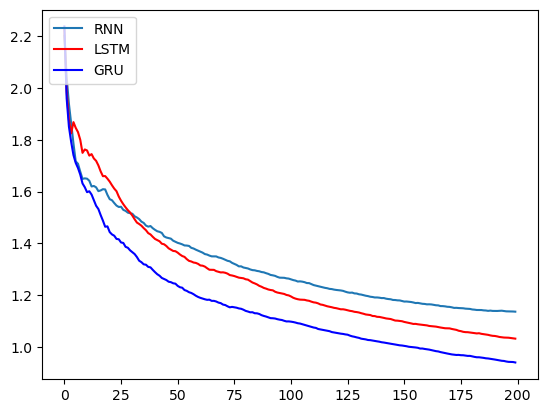

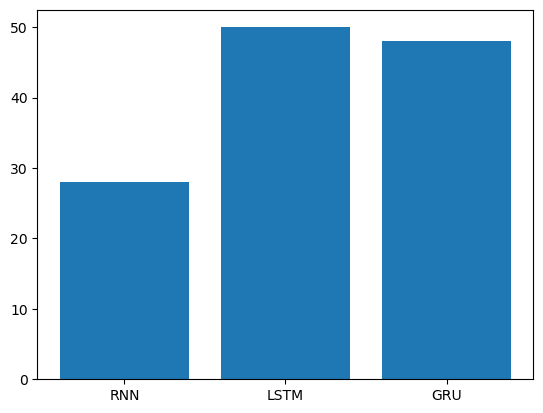

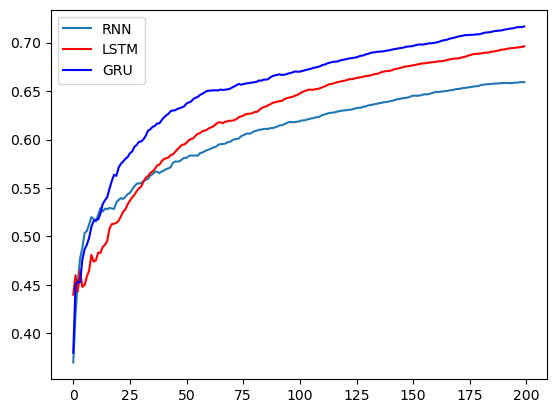

In [26]:
def dm_test_train_rnn_lstm_gru():
    with open('rnn_result.json','r') as fr:
        rnn_dict = json.loads(fr.read())
    with open('lstm_result.json','r') as fr:
        lstm_dict = json.loads(fr.read())
    with open('gru_result.json','r') as fr:
        gru_dict = json.loads(fr.read())
    plt.figure(0)
    plt.plot(rnn_dict["total_loss_list"],label = 'RNN')
    plt.plot(lstm_dict["total_loss_list"],label = 'LSTM',color = 'red')
    plt.plot(gru_dict["total_loss_list"],label = 'GRU',color = 'blue')
    plt.legend(loc = 'upper left')
    plt.savefig('./ai23_avg_loss.png')
    plt.show()
    #绘制柱状图 对比时间
    plt.figure(1)
    x_data = ['RNN','LSTM','GRU']
    y_data = [rnn_dict['total_time'],lstm_dict['total_time'],gru_dict['total_time'],]
    plt.bar(range(len(x_data)),y_data,tick_label = x_data )
    plt.savefig('./ai23_bar_loss.png')
    plt.show()
    
    plt.figure(2)
    plt.plot(rnn_dict["total_acc_list"],label = 'RNN')
    plt.plot(lstm_dict["total_acc_list"],label = 'LSTM',color = 'red')
    plt.plot(gru_dict["total_acc_list"],label = 'GRU',color = 'blue')
    plt.legend(loc = 'upper left')
    plt.savefig('./ai23_avg_acc.png')
    plt.show()
dm_test_train_rnn_lstm_gru()

In [35]:
#预测函数的实现
my_path_rnn = './my_rnn_model_1.bin'
my_path_lstm = './my_lstm_model_1.bin'
my_path_gru = './my_gru_model_1.bin'
#将人名转为向量的函数
def lineToTensor(x):
    tensor_x = torch.zeros(len(x),n_letters)
    for li,letter in enumerate(x):
        tensor_x[li][all_letters.find(letter)] = 1
    return tensor_x
    #lineToTensor(x = 'bai')

In [41]:
#构建rnn预测函数
def my_predict_rnn(x):
    n_letters = 57
    n_hidden = 128
    n_categories = 18
    x_tensor = lineToTensor(x)
    my_rnn = RNN(n_letters,n_hidden,n_categories)
    my_rnn.load_state_dict(torch.load(my_path_rnn))
    #梯度不更新
    with torch.no_grad():
        #将数据送入模型
        h0 = my_rnn.inithidden()
        output,hn = my_rnn(x_tensor,h0)
        #最大值索引 取前三个#取值 取索引
        topv,topi = torch.topk(output,k=3,dim=-1)
        for i in range(3):
            tempv = topv[0][i]
            tempi = topi[0][i]
            class_test = categorys[tempi]
            print(tempv)
            print(class_test)
my_predict_rnn(x = 'zhang')        

tensor(-0.1589)
Chinese
tensor(-2.7570)
Russian
tensor(-3.0469)
Vietnamese


In [44]:
#构建lstm预测函数
def my_predict_lstm(x):
    n_letters = 57
    n_hidden = 128
    n_categories = 18
    x_tensor = lineToTensor(x)
    my_lstm = LSTM(n_letters,n_hidden,n_categories)
    my_lstm.load_state_dict(torch.load(my_path_lstm))
    #梯度不更新
    with torch.no_grad():
        #将数据送入模型
        h0,c0 = my_lstm.inithidden()
        output,hn,cn= my_lstm(x_tensor,h0,c0)
        #最大值索引 取前三个#取值 取索引
        topv,topi = torch.topk(output,k=3,dim=-1)
        for i in range(3):
            tempv = topv[0][i]
            tempi = topi[0][i]
            class_test = categorys[tempi]
            print(tempv)
            print(class_test)
my_predict_lstm(x = 'zhang')        

tensor(-0.2485)
Chinese
tensor(-2.5981)
Russian
tensor(-2.9336)
Korean


In [46]:
#构建gru预测函数
def my_predict_gru(x):
    n_letters = 57
    n_hidden = 128
    n_categories = 18
    x_tensor = lineToTensor(x)
    my_gru = GRU(n_letters,n_hidden,n_categories)
    my_gru.load_state_dict(torch.load(my_path_gru))
    #梯度不更新
    with torch.no_grad():
        #将数据送入模型
        h0 = my_gru.inithidden()
        output,hn = my_gru(x_tensor,h0)
        #最大值索引 取前三个#取值 取索引
        topv,topi = torch.topk(output,k=3,dim=-1)
        for i in range(3):
            tempv = topv[0][i]
            tempi = topi[0][i]
            class_test = categorys[tempi]
            print(tempv)
            print(class_test)
my_predict_gru(x = 'Aihara')        

tensor(-0.2326)
Japanese
tensor(-2.0023)
Arabic
tensor(-2.8928)
Russian
